# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=180.18849314523848, mobile=False), User(purchased=True, time_on_site=135.67700482149365, mobile=False), User(purchased=True, time_on_site=159.88535379510446, mobile=True), User(purchased=True, time_on_site=257.7835981679507, mobile=True), User(purchased=False, time_on_site=86.99445445027507, mobile=False), User(purchased=False, time_on_site=173.67358829592212, mobile=True), User(purchased=True, time_on_site=44.968058188901246, mobile=True), User(purchased=False, time_on_site=30.15219480121866, mobile=True), User(purchased=False, time_on_site=460.0007745853941, mobile=False), User(purchased=False, time_on_site=122.22911474525455, mobile=True)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,180.188493,False
1,True,135.677005,False
2,True,159.885354,True
3,True,257.783598,True
4,False,86.994454,False


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.395806383057993,5.457727420381445,6.012980358659168,6.370819673044487,6.526220869482321,6.618506115477453,6.744300972093091,6.937814523764514,7.022230321283178,7.738183255456649,...,570.7205763776294,572.579212329361,573.071762294419,577.5607756708825,578.0265919014007,578.8349054472059,584.0914381586123,586.960469433746,588.7975083689481,599.8083961016524
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
True,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,240,233,105,29,28
True,96,131,102,20,16


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.801, 124.278]","(124.278, 243.161]","(243.161, 362.043]","(362.043, 480.926]","(480.926, 599.808]"
purchased,,,,,
False,0.714286,0.64011,0.507246,0.591837,0.636364
True,0.285714,0.35989,0.492754,0.408163,0.363636


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.672,0.622667
True,0.328,0.377333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [20]:
import pandas as pd
# TODO - your code here
# Use what we did live in lecture as an example
persons = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
persons.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


I would guess that the initial data should show some effect of exercise time on weight, presumably it makes weight go down. I also guess that age is the confounding factor. Maybe as age rises, the effect of exercise on weight decreases?

In [16]:
print(pd.crosstab(persons['weight'],persons['exercise_time']).shape)
#pd.crosstab(persons['weight'],persons['exercise_time']) Not good, lets bin both
time_bins = pd.cut(persons['exercise_time'],5)
weight_bins = pd.cut(persons['weight'],10)
age_bins = pd.cut(persons['age'],5)
pd.crosstab(weight_bins, time_bins) 
#it appears that when you weigh more, you exercise less
#but that can't be all

#let's try one of age vs exercise
pd.crosstab(age_bins, time_bins)
# a little more interesting, short exercise actually increases with age
# 2 hours stays the same, more than that has a sudden drop around retirement

#ok now to look at all three
pd.crosstab(time_bins, [age_bins, weight_bins])
#too many columns. What I want is a grid with an x and a y of age and weight
#and then a z of exercise time.

(143, 294)


age             (17.938, 30.4]                                               \
weight         (99.854, 114.6] (114.6, 129.2] (129.2, 143.8] (143.8, 158.4]   
exercise_time                                                                 
(-0.3, 60.0]                 4              6              4              3   
(60.0, 120.0]                4              5              3             12   
(120.0, 180.0]              12              5              9             11   
(180.0, 240.0]              11              8             13             16   
(240.0, 300.0]              11             14             12              3   

age                                                                         \
weight         (158.4, 173.0] (173.0, 187.6] (187.6, 202.2] (202.2, 216.8]   
exercise_time                                                                
(-0.3, 60.0]                5              6              7             10   
(60.0, 120.0]               6              6              4              6   
(120.0, 180.0]              5              5              6              1   
(180.0, 240.0]             13              0              0              0   
(240.0, 300.0]              3              0              0              0   

age                                               ...          (67.6, 80.0]  \
weight         (216.8, 231.4] (231.4, 246.0]      ...       (99.854, 114.6]   
exercise_time                                     ...                         
(-0.3, 60.0]                4              3      ...                    11   
(60.0, 120.0]               0              0      ...                    11   
(120.0, 180.0]              0              0      ...                     9   
(180.0, 240.0]              0              0      ...                     3   
(240.0, 300.0]              0              0      ...                     0   

age                                                                         \
weight         (114.6, 129.2] (129.2, 143.8] (143.8, 158.4] (158.4, 173.0]   
exercise_time                                                                
(-0.3, 60.0]               10              7              7             11   
(60.0, 120.0]              10             11             13             17   
(120.0, 180.0]              4              5              7              8   
(180.0, 240.0]              2              3              1              0   
(240.0, 300.0]              0              0              0              0   

age                                                                         \
weight         (173.0, 187.6] (187.6, 202.2] (202.2, 216.8] (216.8, 231.4]   
exercise_time                                                                
(-0.3, 60.0]                8              6             12             11   
(60.0, 120.0]              15             10              8              7   
(120.0, 180.0]              7              8              0              0   
(180.0, 240.0]              0              0              0              0   
(240.0, 300.0]              0              0              0              0   

age                            
weight         (231.4, 246.0]  
exercise_time                  
(-0.3, 60.0]                4  
(60.0, 120.0]               0  
(120.0, 180.0]              0  
(180.0, 240.0]              0  
(240.0, 300.0]              0  

[5 rows x 50 columns]

In [17]:
#lets do ggplot cause that's pretty easy and intuitive
!pip install ggplot

    100% |████████████████████████████████| 2.2MB 10.1MB/s 


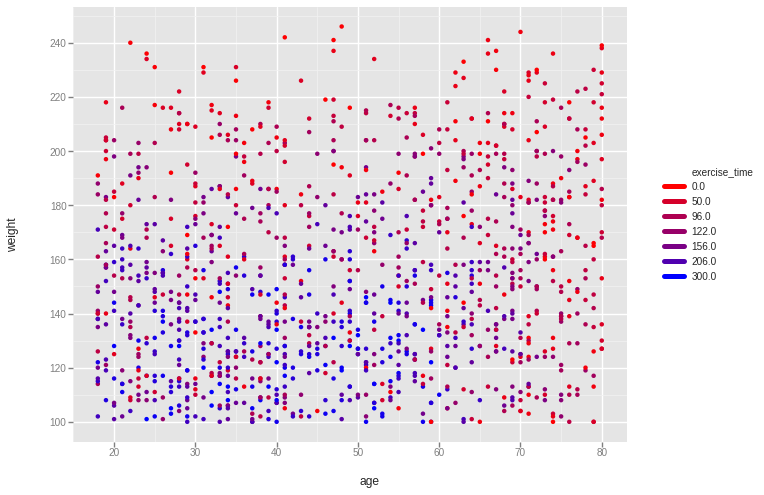

<ggplot: (-9223363281089571261)>

In [47]:
from ggplot import *
#I wonder what that star actually means
ggplot(aes(x='age', y='weight',color='exercise_time'), data = persons) +\
  geom_point() +\
  scale_color_gradient(low='red', high='blue')
#OH BABY, look at this
#I initially thought of a 3d plot with same layout except instead of colors, 
#it would of had bars illustrating exercise time. This is great though. 
#Some of the points are blurred, but it's a small sacrifice for this 
#overall effect

What does this graph say? At both extremes of weight and age, exercise time drops to pretty much zero. One interesting thing to look at is that it drops faster with weight than age. Going horizontal from 220-240 and there's just red. Looking at the 70-80 column, there's still a lot of purple until you pass 220. I also like the visual that vigorous exercise stop around 180-200 and age 60-70. Really cool.

I wish that I could zoom in on this plot because I think some datapoints are over lapping but I'm not sure. Maybe a bekoh plot would have that functionality. 

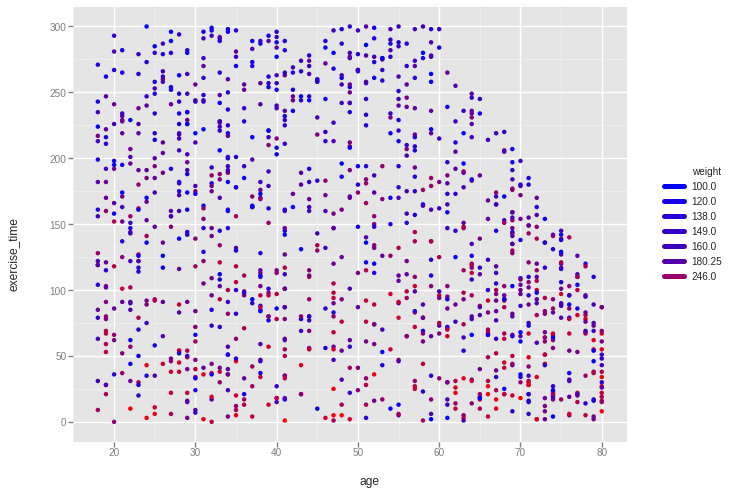

<ggplot: (8755765301312)>

In [44]:
#Let's switch weight and exercise time to see any correlation
ggplot(aes(x='age', y='exercise_time',color='weight'), data = persons) +\
  geom_point() +\
  scale_color_gradient(low='blue', high='red')

I like this format less.  However, it may be better to treat weight as the variable dependant on both ex_time and age. It does show some interesting results. Long exercise times seems to abruptly stop which is definitely worth looking at. 

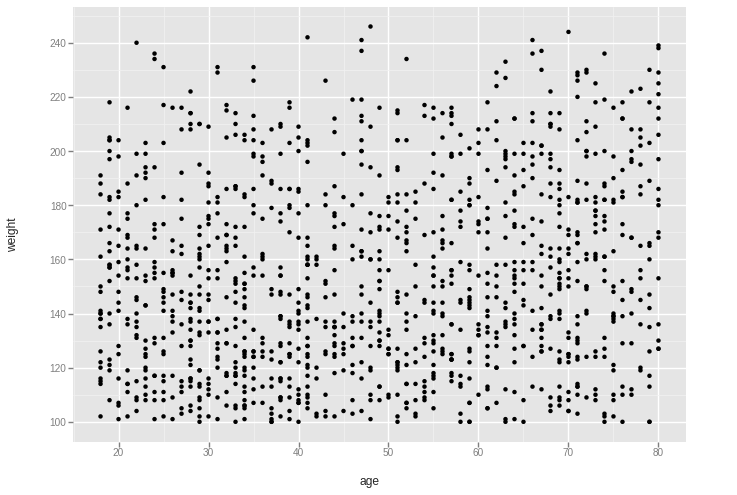

<ggplot: (-9223363281089463608)>

In [45]:
#How about weight vs age. Is weight dependant on age??? Let's find out.
ggplot(aes(x='age', y='weight'), data = persons) +\
  geom_point() 

Nothing that I can see. A density plot was clearer but I need to look up more about that before I can use it and make assertions.

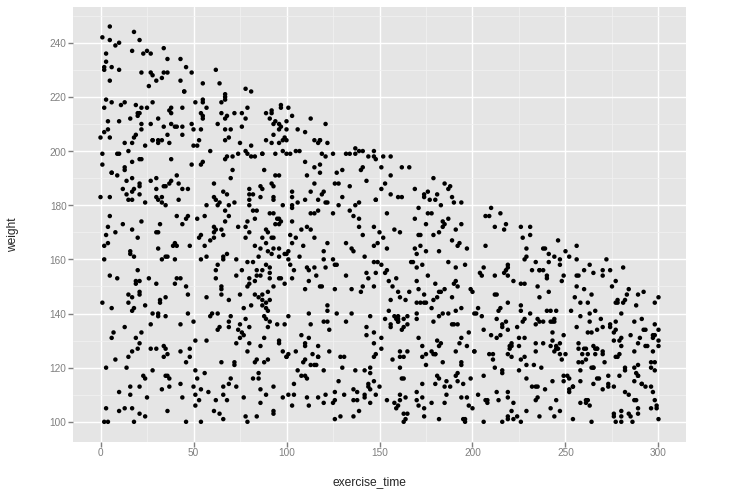

<ggplot: (8755765479530)>

In [41]:
#Does exercise time influence weight?
ggplot(aes(x = 'exercise_time', y = 'weight'),data = persons) +\
  geom_point()

Wow, just look at that. Looks really good as a scatter plot.

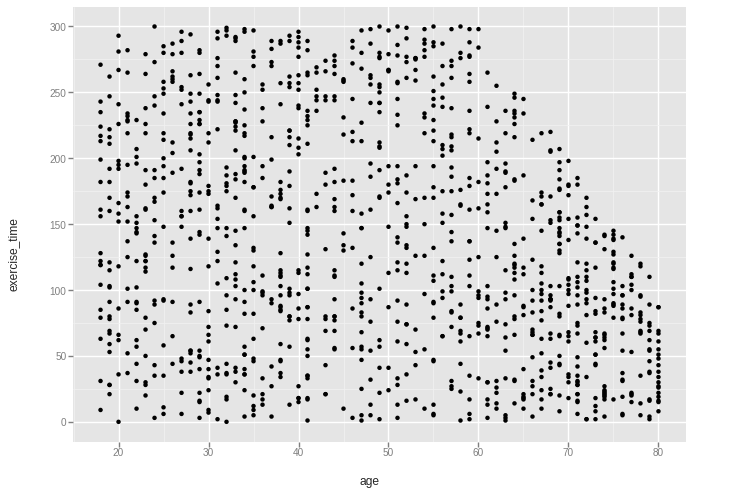

<ggplot: (8755765238248)>

In [46]:
#Does age influence exercise time?
ggplot(aes(x = 'age', y = 'exercise_time'),data = persons) +\
  geom_point()

The general shape looks very similar to the second colored point chart I did.

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


1. The variables are age, weight and exercise time. They are all continuous. Well at least that's what I want to say but looking back at the data they each seem to be discrete; all of them are integers. 

2. The relationship that I saw was that exercise time went down as weight or age increased.

3. I'm not really sure what to say to this. I feel like all three factors are inter-related. Age is independant but I feel it influences at least exercise time

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)